## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'data/planet/'

In [4]:
# Data preparation steps if you are using Crestle:

# os.makedirs('data/planet/models', exist_ok=True)
# os.makedirs('/cache/planet/tmp', exist_ok=True)

# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/test-jpg {PATH}
# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
# !ln -s /cache/planet/tmp {PATH}

In [5]:
ls {PATH}

models/  test-jpg/  train-jpg/  train_v2.csv


## Multi-label versus single-label classification

In [6]:
from fastai.plots import *

In [7]:
def get_1st(path): return glob(f'{path}/*.*')[0]

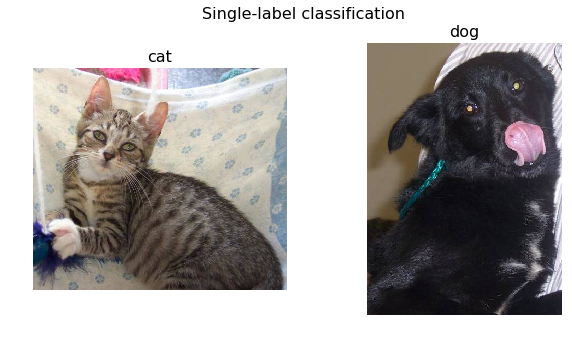

In [8]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

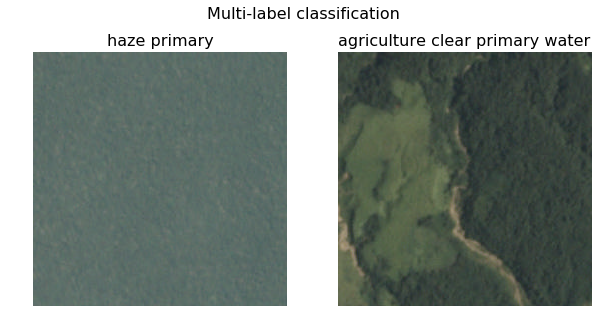

In [9]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [10]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [11]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [12]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [13]:
data = get_data(256)

In [14]:
x, y = next(iter(data.val_dl))

In [15]:
y


    1     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [16]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

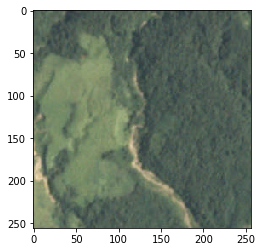

In [17]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [18]:
sz=64

In [19]:
data = get_data(sz)

In [20]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [21]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.232595   0.354678   0.802101  



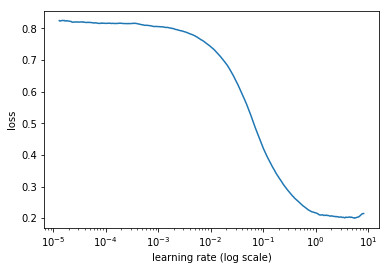

In [22]:
lrf=learn.lr_find()
learn.sched.plot()

In [23]:
lr = 0.2

In [24]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.146155   0.13275    0.883413  
    1      0.140556   0.127468   0.889829                    
    2      0.137204   0.125264   0.89257                     
    3      0.140631   0.124765   0.891836                    
    4      0.135739   0.122366   0.894705                    
    5      0.130057   0.121458   0.894536                    
    6      0.131464   0.121233   0.895744                    



[array([ 0.12123]), 0.89574387304596415]

In [25]:
lrs = np.array([lr/9,lr/3,lr])

In [26]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.11932    0.109036   0.908793  
    1      0.115421   0.109594   0.908439                    
    2      0.110388   0.100859   0.916263                    
    3      0.112      0.105231   0.910902                    
    4      0.107285   0.101273   0.912377                    
    5      0.10224    0.096964   0.918551                    
    6      0.098513   0.097344   0.918879                     



[array([ 0.09734]), 0.91887921906353254]

In [27]:
learn.save(f'{sz}')

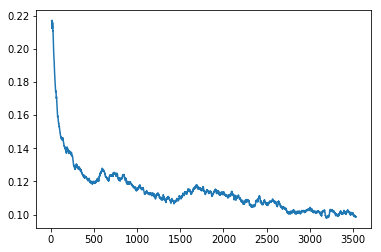

In [28]:
learn.sched.plot_loss()

In [29]:
sz=128

In [30]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.099366   0.094902   0.918323  
    1      0.102555   0.093512   0.920455                     
    2      0.098436   0.092677   0.920057                     
    3      0.100125   0.093363   0.919723                     
    4      0.096996   0.091872   0.921654                     
    5      0.095342   0.091806   0.921337                     
    6      0.093666   0.092272   0.92019                      



[array([ 0.09227]), 0.92019037003762916]

In [31]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.093281   0.086849   0.92791   
    1      0.092315   0.087122   0.927296                     
    2      0.091904   0.084743   0.929472                     
    3      0.094951   0.088409   0.924467                     
    4      0.087336   0.084911   0.92845                      
    5      0.087329   0.083707   0.929477                     
    6      0.08613    0.083494   0.930187                     



In [32]:
sz=256

In [33]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.091855   0.08728    0.926976  
    1      0.090893   0.086736   0.928114                     
    2      0.088804   0.086673   0.928238                     
    3      0.089886   0.08642    0.927904                     
    4      0.09017    0.085637   0.929031                     
    5      0.087472   0.085509   0.928804                     
    6      0.085871   0.085524   0.928982                     



[array([ 0.08552]), 0.92898205788814936]

In [34]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.088821   0.082535   0.93138   
    1      0.089769   0.083654   0.929676                     
    2      0.084384   0.081625   0.932486                     
    3      0.086401   0.085176   0.929141                     
    4      0.084205   0.082215   0.932026                     
    5      0.081152   0.081373   0.932457                     
    6      0.079512   0.08102    0.933564                     



In [35]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [36]:
f2(preds,y)

0.93210871030914033